>>> conducting external validation, this means that I will be using a dataset that has not been used in the training of the CardioTox Net model, the dataset is from Drugbank provided by X. Zhang under hERG and non-hERG blockers

In [29]:
# import library packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns 
from ersilia import ErsiliaModel

from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit import RDLogger
from rdkit.Chem import AllChem
RDLogger.DisableLog("rsAPP")

from sklearn.metrics import roc_auc_score, roc_curve

from standardiser import standardise

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


In [2]:
# load data
def load_data(path):
    data = pd.read_excel(path)
    return data

# load the external test set 
external_data = load_data("/workspaces/codespaces-jupyter/es/ersilia_machine_learning/data/zhang.xlsx") 

# preview the data
external_data.head()

,smile,value
0,O=C1CCCN1C1CCN(Cc2ccc(Oc3nc4ccccc4s3)cc2)CC1,0
1,O=C(c1ccc(F)cc1F)N1CCN(c2ccc(OCCCN3CCCCCC3)cc2...,0
2,COCCCc1cc(CN(C(=O)C2CNCCC2c2cc(=O)n(C)c3ccccc2...,0
3,Cc1c([C@H]2CN3CCN(C(=O)Cc4ccc(-n5cnnn5)nc4)C[C...,0
4,Cc1cc(NCc2c(Cl)ccc(Cl)c2Cl)c2cccc(C(N)=O)c2n1,1


### Data Understanding

In [3]:
def check_data_info(data):
    print(data.info())
    print(f"The dataset has {data.shape[0]} rows and {data.shape[1]} columns")

check_data_info(external_data)
    

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10280 entries, 0 to 10279
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   smile   10280 non-null  object
 1   value   10280 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 160.8+ KB
None
The dataset has 10280 rows and 2 columns


***There are a total of 10,280 entries in the dataset, the dataset contains two columns which is the smile and the value that indicates whether the dataset is a hERG or a non-hERG blocker.***

### Duplicates

In [4]:
def solve_duplicates(data):
    duplicates = data.duplicated().sum()

    if duplicates > 0:
        data.drop_duplicates(inplace = True)
        
solve_duplicates(external_data)

In [5]:
# preview shape of the dataframe
def check_shape(data):
    return data.shape

check_shape(external_data)

(10025, 2)

### Missing Values

In [6]:
def solve_missing_values(data):
    missing_values = data.isna().sum().sum()
    if missing_values > 0:
        print(f"There are {missing_values} missing values")
        data.dropna(inplace = True)

solve_missing_values(external_data)

In [7]:
# check shape
check_shape(external_data)

(10025, 2)

In [8]:
# preview the dataframe
external_data.head()

,smile,value
0,O=C1CCCN1C1CCN(Cc2ccc(Oc3nc4ccccc4s3)cc2)CC1,0
1,O=C(c1ccc(F)cc1F)N1CCN(c2ccc(OCCCN3CCCCCC3)cc2...,0
2,COCCCc1cc(CN(C(=O)C2CNCCC2c2cc(=O)n(C)c3ccccc2...,0
3,Cc1c([C@H]2CN3CCN(C(=O)Cc4ccc(-n5cnnn5)nc4)C[C...,0
4,Cc1cc(NCc2c(Cl)ccc(Cl)c2Cl)c2cccc(C(N)=O)c2n1,1


In [9]:
# create new column
# translates to 1 if hERG blocker and 0 if non-hERG blocker 
external_data['hERG_Classification'] = external_data["value"].apply(lambda x: 'blocker' if x == 1 else 'non-blocker')

In [10]:
external_data.head()

,smile,value,hERG_Classification
0,O=C1CCCN1C1CCN(Cc2ccc(Oc3nc4ccccc4s3)cc2)CC1,0,non-blocker
1,O=C(c1ccc(F)cc1F)N1CCN(c2ccc(OCCCN3CCCCCC3)cc2...,0,non-blocker
2,COCCCc1cc(CN(C(=O)C2CNCCC2c2cc(=O)n(C)c3ccccc2...,0,non-blocker
3,Cc1c([C@H]2CN3CCN(C(=O)Cc4ccc(-n5cnnn5)nc4)C[C...,0,non-blocker
4,Cc1cc(NCc2c(Cl)ccc(Cl)c2Cl)c2cccc(C(N)=O)c2n1,1,blocker


In [11]:
# load training set to 
# check for data leakage
# remove smiles present in
# both the training and the external set 

eos2ta5_test_set = pd.read_csv("/workspaces/codespaces-jupyter/es/ersilia_machine_learning/data/external_test_set_pos.csv")

ext_smiles_set = set(external_data['smile'])
train_smiles_set = set(eos2ta5_test_set['smiles'])

similar_smiles = ext_smiles_set.intersection(train_smiles_set)

if similar_smiles:
    print(" Data Leakage Detected")
    print(similar_smiles)
    external_data = external_data[~external_data['smile'].isin(similar_smiles)]
else:
    print("No data leakage")

 Data Leakage Detected
{'CCCCCCCC[N+](CC)(CC)CC', 'CC(C)N(CCC(C(N)=O)(c1ccccc1)c1ccccn1)C(C)C', 'COc1ccc(CN(CCN(C)C)c2ccccn2)cc1', 'CCOc1cc(N)c(Cl)cc1C(=O)NCC1CN(Cc2ccc(F)cc2)CCO1', 'CCCCCCC[N+](CC)(CC)CCCCc1ccc(Cl)cc1', 'COc1ccccc1OCCNC[C@@H](O)COc1cccc2[nH]c3ccccc3c12'}


In [12]:
# preview external data shape
check_shape(external_data)

(10018, 3)

In [14]:
# let's validate with only 2000 samples
external_data_indexed = external_data.iloc[1:2001]

# preview shape
check_shape(external_data_indexed)

(2000, 3)

### Molecular Validation

In [15]:

# generate smiles list
ext_smiles_list = external_data_indexed['smile'].astype(str).tolist()

# convert smiles_list to tuple
smiles_tuple = tuple(ext_smiles_list)

valid_molecules = []
invalid_molecules = []

for i in smiles_tuple:

    # convert SMILES to molecules
    mols = Chem.MolFromSmiles(i, sanitize = False) 
    mols.UpdatePropertyCache(strict=False)
    
    # sanitize molecules for validity
    Chem.SanitizeMol(mols) 
    
    if Chem.SanitizeMol(mols) == 0:
        valid_molecules.append(mols) # append valid molecules to the list valid molecules
    else:
        invalid_molecules.append(mols) # append invalid molecules to the list invalid molecules

# count valid and invalid SMILES
print(f"Number of molecules sanitized successfully: {len(valid_molecules)}")
print(f"Number of invalid SMILES: {len(invalid_molecules)}")

Number of molecules sanitized successfully: 2000
Number of invalid SMILES: 0


### Molecular Standardization

In [19]:
def standardise_smiles(smiles):
    mols = []
    for smi in smiles:
        try:
            mol = Chem.MolFromSmiles(smi)
        except:
            mol=np.nan
        mols += [mol]
    st_mols = []
    for mol in mols:
        if mol is not None:
            try:
                st_mol = standardise.run(mol)
            except:
                st_mol = np.nan
        else:
            st_mol = np.nan
        st_mols += [st_mol]
    st_smiles = []
    for st_mol in st_mols:
        if st_mol is not None:
            try:
                st_smi = Chem.MolToSmiles(st_mol)
            except:
                st_smi=np.nan
        else:
            st_smi = np.nan
        st_smiles += [st_smi]
    return st_smiles

In [20]:
standardise_smiles(ext_smiles_list)

['O=C(c1ccc(F)cc1F)N1CCN(c2ccc(OCCCN3CCCCCC3)cc2)C(=O)C1',
 'COCCCc1cc(CN(C(=O)C2CNCCC2c2cc(=O)n(C)c3ccccc23)C2CC2)cc(OCCOC)c1',
 'Cc1c([C@H]2CN3CCN(C(=O)Cc4ccc(-n5cnnn5)nc4)C[C@H]3CO2)ccc(F)c1C#N',
 'Cc1cc(NCc2c(Cl)ccc(Cl)c2Cl)c2cccc(C(N)=O)c2n1',
 'CC(C)N(CCO)Cc1nc(-c2cn(CC3CCOCC3)c3c(Cl)cccc23)sc1Cl',
 'CN(C)C(=O)[C@@H](CO)N(C)Cc1ccc2c(c1)CC[C@H](N1CCN(CCc3ccc(F)cc3)CC1=O)C2',
 'N#Cc1c(-c2ccccc2)cc(-c2ccccc2)nc1/N=C1\\S/C(=C2\\SC(c3ccccc3)=NN2c2ccccc2)C(=O)N1c1ccccc1',
 'O=C1[C@@H]2[C@H](C(=O)N1CCCCN1CCN(c3cccc4sccc34)CC1)[C@H]1C=C[C@@H]2C1',
 'COc1cccc(C(C)N2C3CCC2CC(Oc2cccc(C(N)=O)c2)C3)c1',
 'CN(C)C(=O)CC(NC(=O)C1(N)CCCN(c2ncnc3[nH]ccc23)C1)c1ccc(Cl)cc1',
 'Fc1ccc(-c2[nH]c3cc(F)ccc3c2[C@H]2CCCNC2)cc1',
 'COc1ccc([C@@H](C)N[C@@H]2CC[C@@H](C(=O)N3CCC(c4ccccc4)(N4CCCCC4)CC3)C(C)(C)C2)cc1',
 'Cc1cnc(NC(=O)[C@H](COC2CCC2)Oc2ncnc3c2cnn3-c2ccccc2Cl)cn1',
 'COc1cc(C(=O)NCCN2CCCC2)ccc1Oc1ccc(Cl)cc1NS(=O)(=O)c1ccc(Cl)c(C(F)(F)F)c1',
 'Cc1cc(C2CCCCC2)n(O)c(=O)c1',
 'Cc1ccc2c(N3CCN(CCc4cccc(

In [21]:
# instantiate model
model = ErsiliaModel("eos2ta5")

# serve model
model.serve()

# make predictions
# store predictions in a pandas dataframe
external_data_output = model.run(ext_smiles_list, output = 'pandas')

In [22]:
external_data_output.to_csv("/workspaces/codespaces-jupyter/es/ersilia_machine_learning/data/zhang-external-output-predictions.csv", index=False)

In [23]:
# load external data output
zhang_ext_output_pred = pd.read_csv("/workspaces/codespaces-jupyter/es/ersilia_machine_learning/data/zhang-external-output-predictions.csv")
zhang_ext_output_pred


,key,input,probability
0,FOCPBTUUAJZSNL-UHFFFAOYSA-N,O=C(c1ccc(F)cc1F)N1CCN(c2ccc(OCCCN3CCCCCC3)cc2...,0.081555
1,GQLRKTKPJZISGL-UHFFFAOYSA-N,COCCCc1cc(CN(C(=O)C2CNCCC2c2cc(=O)n(C)c3ccccc2...,0.088940
2,VEJAXNJBZFJBNE-LAUBAEHRSA-N,Cc1c([C@H]2CN3CCN(C(=O)Cc4ccc(-n5cnnn5)nc4)C[C...,0.045078
3,CDSXVXMUMRBIGJ-UHFFFAOYSA-N,Cc1cc(NCc2c(Cl)ccc(Cl)c2Cl)c2cccc(C(N)=O)c2n1,0.926566
4,LUTXPPYCQADQQH-UHFFFAOYSA-N,CC(C)N(CCO)Cc1nc(-c2cn(CC3CCOCC3)c3c(Cl)cccc23...,0.926728
...,...,...,...
1995,HKPZPUQMQIZENN-UHFFFAOYSA-N,Cl.FCCOc1ccccc1CCC1CCN(CCc2ccc(F)cc2)CC1,0.926676
1996,INIIDTFMHZRHDG-UHFFFAOYSA-N,Fc1ccc(CN2CCN(C3=Nn4c(nnc4C(F)(F)F)CC3)CC2)cc1,0.067932
1997,OMXJWXICMCUBRZ-UHFFFAOYSA-N,Cn1c(SCCCN2CC3CCN(c4ccc(F)cc4F)C3C2)nnc1-c1cnccn1,0.926722
1998,DOQIAUOAJLSPND-UHFFFAOYSA-N,CS(=O)(=O)c1ccc(-c2cccc(F)c2)c(C(=O)N2Cc3cn(-c...,0.165435


In [24]:
zhang_ext_output_pred["hERG_status"] = zhang_ext_output_pred['probability'].apply(lambda x : 1 if x > 0.5 else 0)
zhang_ext_output_pred['hERG_blocker_classification'] = zhang_ext_output_pred['hERG_status'].apply(lambda x: 'blocker' if x == 1 else 'non-blocker')
zhang_ext_output_pred.head()

,key,input,probability,hERG_status,hERG_blocker_classification
0,FOCPBTUUAJZSNL-UHFFFAOYSA-N,O=C(c1ccc(F)cc1F)N1CCN(c2ccc(OCCCN3CCCCCC3)cc2...,0.081555,0,non-blocker
1,GQLRKTKPJZISGL-UHFFFAOYSA-N,COCCCc1cc(CN(C(=O)C2CNCCC2c2cc(=O)n(C)c3ccccc2...,0.088940,0,non-blocker
2,VEJAXNJBZFJBNE-LAUBAEHRSA-N,Cc1c([C@H]2CN3CCN(C(=O)Cc4ccc(-n5cnnn5)nc4)C[C...,0.045078,0,non-blocker
3,CDSXVXMUMRBIGJ-UHFFFAOYSA-N,Cc1cc(NCc2c(Cl)ccc(Cl)c2Cl)c2cccc(C(N)=O)c2n1,0.926566,1,blocker
4,LUTXPPYCQADQQH-UHFFFAOYSA-N,CC(C)N(CCO)Cc1nc(-c2cn(CC3CCOCC3)c3c(Cl)cccc23...,0.926728,1,blocker


In [25]:
y_true = external_data_indexed['value']
y_pred = zhang_ext_output_pred['hERG_status']

score = roc_auc_score(y_true, y_pred)
print(f"The AUROC score is {round(score, 4)}")

The AUROC score is 0.8787


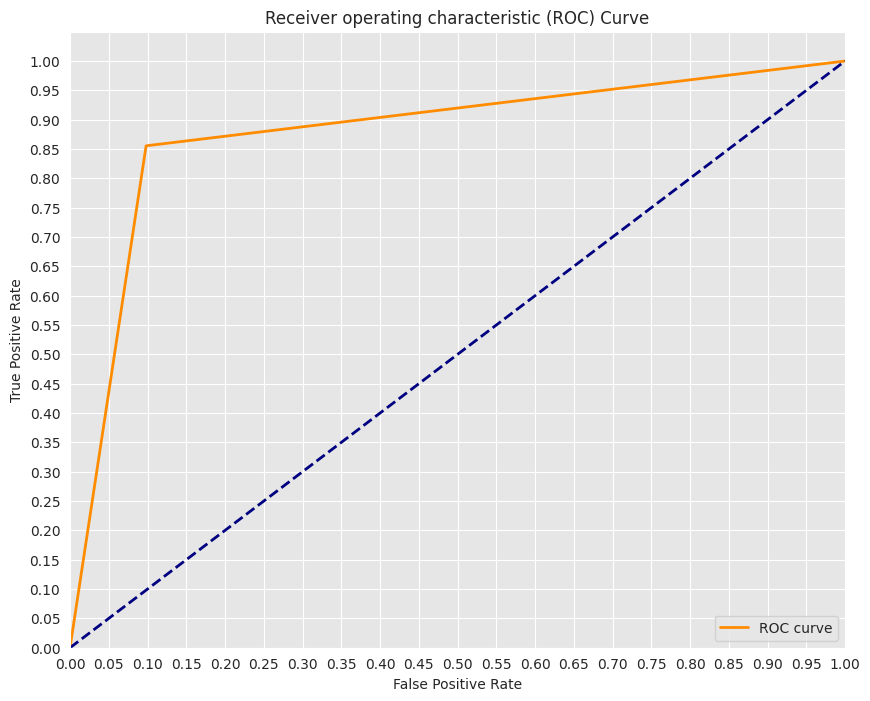

In [28]:
fpr, tpr, thresholds = roc_curve(y_true, y_pred)

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()